# Testing H2O AutoML & few libraries for interactive EDA

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib as plt
import scipy as sp
import xgboost as xgb
from sklearn.model_selection import train_test_split
import pandas_profiling as pdp # Interactive EDA via pandas extension
# Import modules to work with data visualization offline
from plotly.offline import plot, iplot, init_notebook_mode
# Connect JavaScript to the notebook with the init_notebook_mode() method 
init_notebook_mode(connected = True)
import cufflinks as cf
# Update to cufflinks offline
cf.go_offline()

In [2]:
# Import H2O framework
import h2o
from h2o.automl import H2OAutoML

In [3]:
# Initialize server for H2O
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_212"; OpenJDK Runtime Environment (build 1.8.0_212-8u212-b03-0ubuntu1.16.04.1-b03); OpenJDK 64-Bit Server VM (build 25.212-b03, mixed mode)
  Starting server from /home/pavel/anaconda3/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmplpqfb28u
  JVM stdout: /tmp/tmplpqfb28u/h2o_pavel_started_from_python.out
  JVM stderr: /tmp/tmplpqfb28u/h2o_pavel_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Moscow
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.1
H2O cluster version age:,12 days
H2O cluster name:,H2O_from_python_pavel_g1cd57
H2O cluster total nodes:,1
H2O cluster free memory:,3.458 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [4]:
# Upload dataset
data = pd.read_csv('/home/pavel/anaconda3/Scripts/IncomeClassification/income_evaluation.csv')

In [5]:
data.shape # Dataset dimension

(32561, 15)

In [6]:
data.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [8]:
# Distribution for target variable
data[' sex'].value_counts(normalize=True)

 Male      0.669205
 Female    0.330795
Name:  sex, dtype: float64

# Let's run magic 'pandas-profiling' Lib and build EDA report for our dataset

In [9]:
pdp.ProfileReport(data)

/home/pavel/anaconda3/lib/python3.5/site-packages/pandas_profiling/__init__.py:53: UserWarning:

Sorting is supported from Python 3.6+



# Run iPlot to build interactive graphs and charts

In [10]:
data['age'].iplot(kind='hist',bins=30)

In [11]:
edu_distribution = data.groupby('_education').size().reset_index()
edu_distribution  = pd.DataFrame(edu_distribution)
edu_distribution.columns = ['Education','Amount']
edu_distribution.iplot(kind='pie',labels='Education', values='Amount')

# Lets import dataset via H20 Frame

In [15]:
df = h2o.import_file(path = '/home/pavel/anaconda3/Scripts/IncomeClassification/income_evaluation.csv')

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [16]:
train,validation = df.split_frame(ratios=[.6],seed = 12345)

In [17]:
y = 'sex'
x = ['age', 'workclass', 'fnlwgt','education','marital-status','occupation','relationship','race','capital-gain',
    'capital-loss','hours-per-week','native-country','income']

# Run AutoML

In [19]:
aml = H2OAutoML(max_models = 30, max_runtime_secs=300, seed = 1)
aml.train(x = x, y = y, training_frame = train, validation_frame = validation)

AutoML progress: |████████████████████████████████████████████████████████| 100%


# Leaderboard

In [20]:
lb = aml.leaderboard
lb.head()

model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_AutoML_20190728_000033,0.935523,0.307545,0.187497,0.315653,0.0996367
StackedEnsemble_AllModels_AutoML_20190728_000033,0.935158,0.304636,0.18133,0.315208,0.0993562
XGBoost_1_AutoML_20190728_000033,0.934665,0.290559,0.183635,0.312451,0.0976257
GBM_1_AutoML_20190728_000033,0.934524,0.293315,0.188265,0.312998,0.0979675
XGBoost_3_AutoML_20190728_000033,0.934316,0.291759,0.182869,0.313034,0.0979904
GBM_5_AutoML_20190728_000033,0.934305,0.293809,0.18953,0.313565,0.0983232
GBM_2_AutoML_20190728_000033,0.934054,0.29442,0.182214,0.313568,0.098325
GBM_3_AutoML_20190728_000033,0.933717,0.295585,0.183168,0.314263,0.0987611
XGBoost_2_AutoML_20190728_000033,0.933341,0.294458,0.189946,0.314388,0.09884
GBM_4_AutoML_20190728_000033,0.932507,0.2993,0.194098,0.316271,0.100027


In [21]:
# print the auc for the validation data
print('AUC on validation is ',  aml.leader.auc(valid=True))
print('GINI on validation is ', 2 * aml.leader.auc(valid=True) - 1 )

AUC on validation is  0.9372579528028254
GINI on validation is  0.8745159056056508


In [22]:
# let's calculate prediction for validation dataset
pred=aml.leader.predict(validation)
pred

stackedensemble prediction progress: |████████████████████████████████████| 100%


predict,Female,Male
Male,0.024999,0.975001
Female,0.961035,0.0389648
Female,0.965216,0.0347836
Male,0.0244615,0.975539
Male,0.0244771,0.975523
Male,0.0244761,0.975524
Male,0.0244678,0.975532
Male,0.0244468,0.975553
Male,0.0405522,0.959448
Male,0.0245181,0.975482


In [23]:
# Compare our predictions with real target
pred.concat(validation['sex'])

predict,Female,Male,sex
Male,0.024999,0.975001,Male
Female,0.961035,0.0389648,Female
Female,0.965216,0.0347836,Female
Male,0.0244615,0.975539,Male
Male,0.0244771,0.975523,Male
Male,0.0244761,0.975524,Male
Male,0.0244678,0.975532,Male
Male,0.0244468,0.975553,Male
Male,0.0405522,0.959448,Male
Male,0.0245181,0.975482,Male


# Ensemble exploration

In [58]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(aml.leader.metalearner()['name'])

In [59]:
metalearner.coef_norm()

{'DRF_1_AutoML_20190726_013630': 0.18401195448931118,
 'DeepLearning_1_AutoML_20190726_013630': 1.1790367659212972e-05,
 'GBM_1_AutoML_20190726_013630': 0.23127626359210873,
 'GLM_grid_1_AutoML_20190726_013630_model_1': 0.13432592607641972,
 'Intercept': 1.3935471641797548,
 'XGBoost_3_AutoML_20190726_013630': 1.796526666494771,
 'XRT_1_AutoML_20190726_013630': 0.18209835979043235}

/home/pavel/anaconda3/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning:


Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.



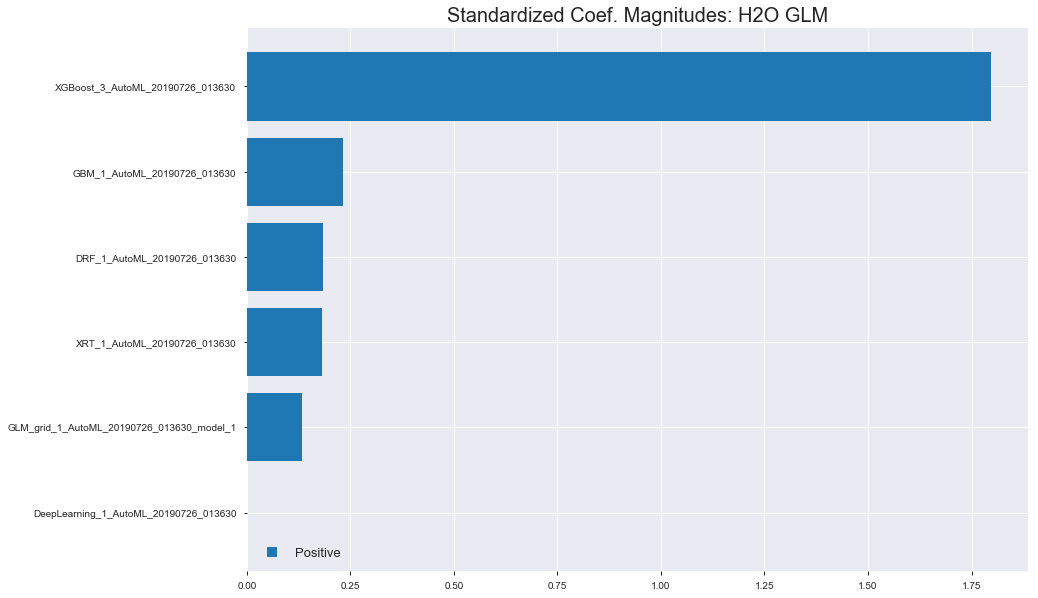

In [60]:
%matplotlib inline
metalearner.std_coef_plot()

### The most impact has XGboost model in ensemble.